In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nengo
import scipy
import time
import itertools
from fit import *
from NEF_syn import *
from environments import *
palette = sns.color_palette('tab10')
sns.set_palette(palette)
sns.set(context='paper', style='white', font="cmr10", font_scale=1.2)
plt.rcParams['axes.formatter.use_mathtext'] = True

In [2]:
def run_bayesian(sid, noise):
    human = pd.read_pickle(f"data/carrabin.pkl").query("sid==@sid")
    params = [noise, 0]
    dfs = []
    columns = ['type', 'sid', 'trial', 'stage', 'qid', 'response']
    for trial in human['trial'].unique():
        for stage in human['stage'].unique():
            qid = human.query("trial==@trial and stage==@stage")['qid'].unique()[0]
            response = get_expectations_carrabin("B_n", params, sid, trial, stage)
            dfs.append(pd.DataFrame([["B_n", sid, trial, stage, qid, response]], columns=columns))
    dynamics_data = pd.concat(dfs, ignore_index=True)
    dynamics_data['noise'] = noise
    return dynamics_data

In [3]:
def run_rl(sid, sigma):
    human = pd.read_pickle(f"data/carrabin.pkl").query("sid==@sid")
    mu = pd.read_pickle(f"data/RL_n2_carrabin_{sid}_params.pkl")['mu'].unique()[0]
    params = [mu, sigma]
    dfs = []
    columns = ['type', 'sid', 'trial', 'stage', 'qid', 'response']
    for trial in human['trial'].unique():
        for stage in human['stage'].unique():
            qid = human.query("trial==@trial and stage==@stage")['qid'].unique()[0]
            response = get_expectations_carrabin("RL_n", params, sid, trial, stage)
            dfs.append(pd.DataFrame([["RL_n", sid, trial, stage, qid, response]], columns=columns))
    dynamics_data = pd.concat(dfs, ignore_index=True)
    dynamics_data['sigma'] = sigma
    return dynamics_data

In [4]:
def run_nef(sid, n_neurons, dataset="carrabin"):
    empirical = pd.read_pickle(f"data/{dataset}.pkl").query("sid==@sid")
    trials = empirical['trial'].unique()
    params = pd.read_pickle("data/NEF_syn_carrabin_mar31_params.pkl").query("sid==@sid")
    alpha = params['alpha'].unique()[0]
    lambd = params['lambda'].unique()[0]
    columns = ['type', 'sid', 'trial', 'stage', 'qid', 'response']
    dfs = []
    W = np.zeros((1, n_neurons))
    for trial in trials[:20]:
        print(f"training sid {sid}, trial {trial}")
        env = EnvironmentCount(dataset, sid=sid, trial=trial, lambd=lambd)
        net, sim, W = simulate_NEF_syn(W, env, alpha=alpha, n_neurons=n_neurons, z=0, seed_net=sid, train=True)
    for trial in trials:
        print(f"running sid {sid}, trial {trial}")
        env = EnvironmentCount(dataset, sid=sid, trial=trial, lambd=lambd)
        net, sim = simulate_NEF_syn(W, env, alpha=alpha, n_neurons=n_neurons, z=0, seed_net=sid, train=False)
        obs_times = env.obs_times
        for s, tidx in enumerate(obs_times):
            stage = env.stages[s]
            qid = empirical.query("trial==@trial and stage==@stage")['qid'].unique()[0]
            response = np.mean(sim.data[net.probe_value][tidx-100: tidx])
            dfs.append(pd.DataFrame([['NEF_syn', sid, trial, stage, qid, response]], columns=columns))
    dynamics_data = pd.concat(dfs, ignore_index=True)
    dynamics_data['neurons'] = n_neurons
    return dynamics_data

In [5]:
sid = 1
noises = [0.03, 0.06, 0.09]
sigmas = [0.03, 0.06, 0.09]
neurons = [40, 60, 80]

dfs = []
for noise in noises:
    dfs.append(run_bayesian(sid, noise))
bayes = pd.concat(dfs, ignore_index=True)
dfs = []
for sigma in sigmas:
    dfs.append(run_rl(sid, sigma))
rl = pd.concat(dfs, ignore_index=True)
dfs = []
for n in neurons:
    dfs.append(run_nef(sid, n))
nef = pd.concat(dfs, ignore_index=True)

training sid 1, trial 1
training sid 1, trial 2
training sid 1, trial 3
training sid 1, trial 4
training sid 1, trial 5
training sid 1, trial 6
training sid 1, trial 7
training sid 1, trial 8
training sid 1, trial 9
training sid 1, trial 10
training sid 1, trial 11
training sid 1, trial 12
training sid 1, trial 13
training sid 1, trial 14
training sid 1, trial 15
training sid 1, trial 16
training sid 1, trial 17
training sid 1, trial 18
training sid 1, trial 19
training sid 1, trial 20
running sid 1, trial 1
running sid 1, trial 2
running sid 1, trial 3
running sid 1, trial 4
running sid 1, trial 5
running sid 1, trial 6
running sid 1, trial 7
running sid 1, trial 8
running sid 1, trial 9
running sid 1, trial 10
running sid 1, trial 11
running sid 1, trial 12
running sid 1, trial 13
running sid 1, trial 14
running sid 1, trial 15
running sid 1, trial 16
running sid 1, trial 17
running sid 1, trial 18
running sid 1, trial 19
running sid 1, trial 20
running sid 1, trial 21
running sid 1,

In [6]:
def add_excursion(data, noise_label):
    dfs = []
    for sid in data['sid'].unique():
        human = pd.read_pickle(f"data/carrabin.pkl").query("sid==@sid")
        for n in data[noise_label].unique():
            subdata = data.query(f"sid==@sid & {noise_label}==@n").copy()
            print(f"sid {sid}, {noise_label} {n}")
            for i, row in subdata.iterrows():
                trial = row['trial']
                stage = row['stage']
                qid = row['qid']
                response = np.clip(row['response'],-1,1)
                avg_response = subdata.query("qid==@qid")['response'].mean()
                subdata.loc[i, 'excursion'] = response - avg_response
            dfs.append(subdata)
    data_add = pd.concat(dfs, ignore_index=True)
    return data_add

In [35]:
human = pd.read_pickle("data/carrabin.pkl")
human['noise'] = 'human'
human['sigma'] = 'human'
human['neurons'] = 'human'
human_add = add_excursion(human, "noise")
# bayes_add = add_excursion(bayes, "noise")
# rl_add = add_excursion(rl, "sigma")
# nef_add = add_excursion(nef, "neurons")

sid 1, noise human
sid 2, noise human
sid 3, noise human
sid 4, noise human
sid 5, noise human
sid 6, noise human
sid 7, noise human
sid 8, noise human
sid 9, noise human
sid 10, noise human
sid 11, noise human
sid 12, noise human
sid 13, noise human
sid 14, noise human
sid 15, noise human
sid 16, noise human
sid 17, noise human
sid 18, noise human
sid 19, noise human
sid 20, noise human
sid 21, noise human


In [49]:
combined_add = pd.concat([human_add, bayes_add, rl_add, nef_add], ignore_index=True)

In [51]:
combined_add.to_pickle("data/excursion_vs_beta.pkl")

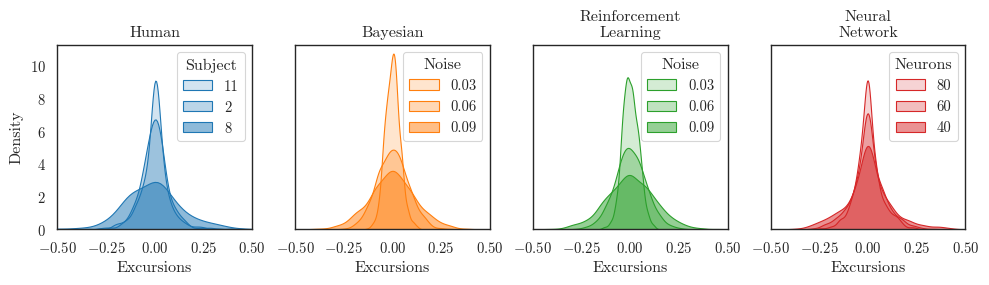

In [48]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3), sharey=True, sharex=True)
alphas = [0.2, 0.3, 0.5]
sids = [11, 2,8]

for i, subject in enumerate(sids):
    sns.kdeplot(combined_add.query("type=='human' & sid==@subject"), x='excursion', ax=axes[0], color=palette[0], fill=True, common_norm=False, alpha=alphas[i], label=f"{subject}")

for i, noise in enumerate(noises):
    sns.kdeplot(combined_add.query("type=='B_n' & noise==@noise"), x='excursion', ax=axes[1], color=palette[1], fill=True, common_norm=False, alpha=alphas[i], label=f"{noise}")

for i, sigma in enumerate(sigmas):
    sns.kdeplot(combined_add.query("type=='RL_n' & sigma==@sigma"), x='excursion', ax=axes[2], color=palette[2], fill=True, common_norm=False, alpha=alphas[i], label=f"{sigma}")

for i, n in enumerate(neurons[::-1]):
    sns.kdeplot(combined_add.query("type=='NEF_syn' & neurons==@n"), x='excursion', ax=axes[3], color=palette[3], fill=True, common_norm=False, alpha=alphas[i], label=f"{n}", )

axes[0].set(xlabel='Excursions', xlim=[-0.5, 0.5])
axes[1].set(xlabel='Excursions')
axes[2].set(xlabel='Excursions')
axes[3].set(xlabel='Excursions')
axes[0].set(title='Human')
axes[1].set(title='Bayesian')
axes[2].set(title='Reinforcement\nLearning')
axes[3].set(title='Neural\nNetwork')
axes[0].legend(title="Subject")
axes[1].legend(title="Noise")
axes[2].legend(title="Noise")
axes[3].legend(title="Neurons")
plt.tight_layout()
fig.savefig("plots/excursions_vs_parameter.jpg", dpi=600)

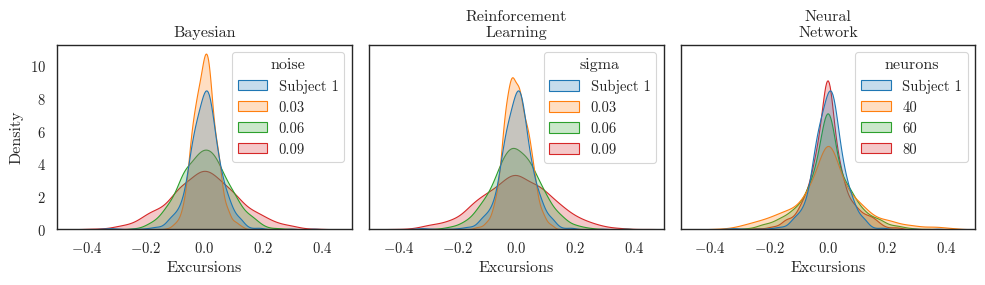

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 3), sharey=True, sharex=True)
bayes_query = ['human', 'B_n']
rl_query = ['human', 'RL_n']
nef_query = ['human', 'NEF_syn']
sns.kdeplot(combined_add.query("type==@bayes_query"), x='excursion', hue='noise', ax=axes[0], palette=palette[:4], fill=True, common_norm=False)
sns.kdeplot(combined_add.query("type==@rl_query"), x='excursion', hue='sigma', ax=axes[1], palette=palette[:4], fill=True, common_norm=False)
sns.kdeplot(combined_add.query("type==@nef_query"), x='excursion', hue='neurons', ax=axes[2], palette=palette[:4], fill=True, common_norm=False)
axes[0].set(xlabel='Excursions', xlim=[-0.5, 0.5])
axes[1].set(xlabel='Excursions')
axes[2].set(xlabel='Excursions')
axes[0].set(title='Bayesian')
axes[1].set(title='Reinforcement\nLearning')
axes[2].set(title='Neural\nNetwork')
plt.tight_layout()
fig.savefig("plots/excursions_vs_parameter.jpg", dpi=600)

### run locally

In [ ]:
sid = 18
alpha = 0.2
n_other = [40, 200]
n_error = [40, 200]
dfs = []
for mt in ['NEF_RL', 'NEF_WM']:
    for n in n_other:
        for e in n_other:
            dfs.append(run_NEF(mt, sid, n, e, alpha))
NEF_data = pd.concat(dfs, ignore_index=True)

### run locally with fitted params

In [11]:
sid = 1
n_neurons = [30, 60, 90]
dfs = []
for mt in ['NEF_WM', 'NEF_RL']:
    params = pd.read_pickle(f"data/{mt}_carrabin_mar6_params.pkl")
    alpha = params['alpha'].unique()[0]
    for n in n_neurons:
        dfs.append(run_NEF(mt, sid, n, alpha))
NEF_data = pd.concat(dfs, ignore_index=True)

NEF_WM, alpha 0.18000000000000002, neurons 30, sid 1, trial 1
NEF_WM, alpha 0.18000000000000002, neurons 30, sid 1, trial 2
NEF_WM, alpha 0.18000000000000002, neurons 30, sid 1, trial 3
NEF_WM, alpha 0.18000000000000002, neurons 30, sid 1, trial 4
NEF_WM, alpha 0.18000000000000002, neurons 30, sid 1, trial 5
NEF_WM, alpha 0.18000000000000002, neurons 30, sid 1, trial 6
NEF_WM, alpha 0.18000000000000002, neurons 30, sid 1, trial 7
NEF_WM, alpha 0.18000000000000002, neurons 30, sid 1, trial 8
NEF_WM, alpha 0.18000000000000002, neurons 30, sid 1, trial 9
NEF_WM, alpha 0.18000000000000002, neurons 30, sid 1, trial 10
NEF_WM, alpha 0.18000000000000002, neurons 30, sid 1, trial 11
NEF_WM, alpha 0.18000000000000002, neurons 30, sid 1, trial 12
NEF_WM, alpha 0.18000000000000002, neurons 30, sid 1, trial 13
NEF_WM, alpha 0.18000000000000002, neurons 30, sid 1, trial 14
NEF_WM, alpha 0.18000000000000002, neurons 30, sid 1, trial 15
NEF_WM, alpha 0.18000000000000002, neurons 30, sid 1, trial 16
N

In [15]:
NEF_data.to_pickle("data/noise_vs_neurons_run_locally.pkl")

### or load

In [9]:
nefrl = pd.read_pickle("data/noise_vs_neurons_NEF_RL_1_feb21two.pkl")
nefwm = pd.read_pickle("data/noise_vs_neurons_NEF_WM_1_feb21two.pkl")
NEF_data = pd.concat([nefrl, nefwm], ignore_index=True)

In [10]:
NEF_data

,type,sid,trial,stage,qid,n_other,n_error,response
0,NEF_WM,1,1,1,1,200,25,0.270312
1,NEF_WM,1,1,2,10,200,25,0.085101
2,NEF_WM,1,1,3,100,200,25,-0.256984
3,NEF_WM,1,1,4,1000,200,25,-0.536487
4,NEF_WM,1,1,5,10000,200,25,-0.676982
...,...,...,...,...,...,...,...,...
5995,NEF_RL,1,200,1,1,40,100,0.092771
5996,NEF_RL,1,200,2,11,40,100,0.178550
5997,NEF_RL,1,200,3,111,40,100,0.261289
5998,NEF_RL,1,200,4,1111,40,100,0.351597


# Calculate alpha and excursion and add to the dataframe

In [10]:
NEF_add = add_excursion_alpha(NEF_data)

NEF_RL sid 1, n_other 40, n_error 40
NEF_RL sid 1, n_other 40, n_error 60
NEF_RL sid 1, n_other 40, n_error 80
NEF_RL sid 1, n_other 40, n_error 100
NEF_RL sid 1, n_other 40, n_error 120
NEF_RL sid 1, n_other 60, n_error 40
NEF_RL sid 1, n_other 60, n_error 60
NEF_RL sid 1, n_other 60, n_error 80
NEF_RL sid 1, n_other 60, n_error 100
NEF_RL sid 1, n_other 60, n_error 120
NEF_RL sid 1, n_other 80, n_error 40
NEF_RL sid 1, n_other 80, n_error 60
NEF_RL sid 1, n_other 80, n_error 80
NEF_RL sid 1, n_other 80, n_error 100
NEF_RL sid 1, n_other 80, n_error 120
NEF_RL sid 1, n_other 100, n_error 40
NEF_RL sid 1, n_other 100, n_error 60
NEF_RL sid 1, n_other 100, n_error 80
NEF_RL sid 1, n_other 100, n_error 100
NEF_RL sid 1, n_other 100, n_error 120
NEF_RL sid 1, n_other 120, n_error 40
NEF_RL sid 1, n_other 120, n_error 60
NEF_RL sid 1, n_other 120, n_error 80
NEF_RL sid 1, n_other 120, n_error 100
NEF_RL sid 1, n_other 120, n_error 120
NEF_WM sid 1, n_other 40, n_error 40
NEF_WM sid 1, n_ot

# Heatmap plot

In [21]:
NEF_add

,type,sid,trial,stage,qid,n_other,n_error,response,excursion,alpha
0,NEF_RL,1,1,1,1,40,40,0.158177,0.015835,NaN
1,NEF_RL,1,1,2,10,40,40,0.022612,0.037178,0.117050
2,NEF_RL,1,1,3,100,40,40,-0.068787,0.080685,0.089378
3,NEF_RL,1,1,4,1000,40,40,-0.146479,-0.001659,0.083431
4,NEF_RL,1,1,5,10000,40,40,-0.240894,0.022663,0.110618
...,...,...,...,...,...,...,...,...,...,...
49995,NEF_WM,1,200,1,1,240,240,0.174063,0.015800,NaN
49996,NEF_WM,1,200,2,11,240,240,0.309800,0.019009,0.164343
49997,NEF_WM,1,200,3,111,240,240,0.425771,0.029911,0.168025
49998,NEF_WM,1,200,4,1111,240,240,0.525403,0.036436,0.173506


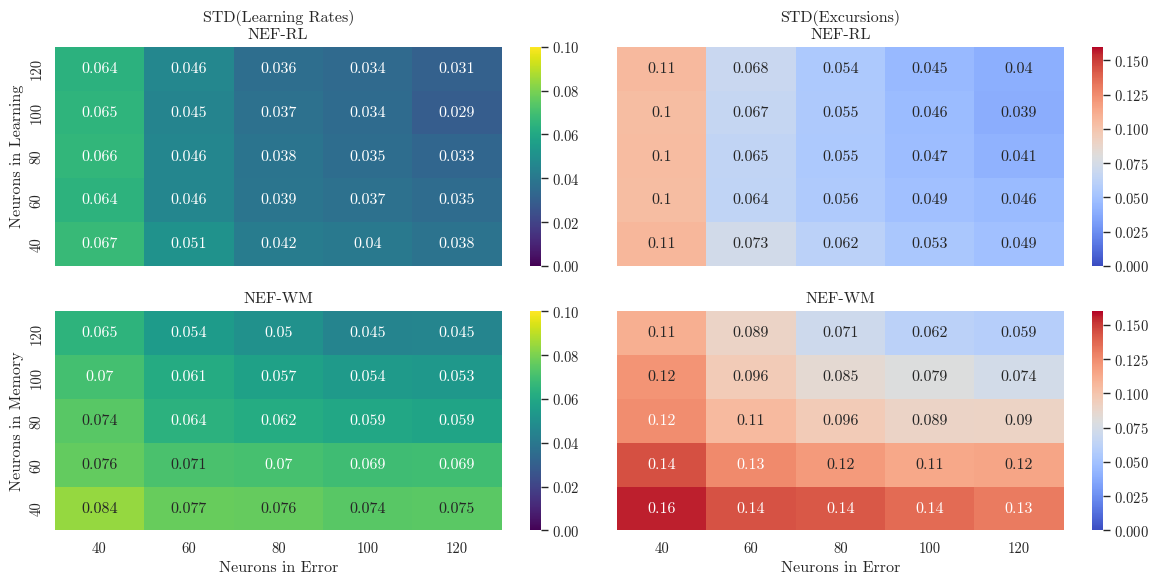

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,6), sharex=True, sharey=True)
for mt, model_type in enumerate(['NEF_RL', 'NEF_WM']):
    alpha_pivot = NEF_add.query("type==@model_type").pivot_table(index='n_other', columns='n_error', values='alpha', aggfunc='std')
    excursion_pivot = NEF_add.query("type==@model_type").pivot_table(index='n_other', columns='n_error', values='excursion', aggfunc='std')
    sns.heatmap(data=alpha_pivot, annot=True, cmap="viridis", ax=axes[mt][0], vmin=0.0, vmax=0.1)
    sns.heatmap(data=excursion_pivot, annot=True, cmap="coolwarm", ax=axes[mt][1], vmin=0.0, vmax=0.16)
    # axes[mt][0].invert_yaxis()
    axes[mt][1].invert_yaxis()
axes[0][0].set(ylabel="Neurons in Learning", xlabel=None, title=f"STD(Learning Rates)\nNEF-RL")
axes[0][1].set(ylabel=None, xlabel=None, title=f"STD(Excursions)\nNEF-RL")
axes[1][0].set(ylabel="Neurons in Memory", xlabel="Neurons in Error", title=f"NEF-WM")
axes[1][1].set(ylabel=None, xlabel="Neurons in Error", title=f"NEF-WM")
plt.tight_layout()
fig.savefig("plots/noise_vs_neurons.jpg", dpi=600)

### Compare to distribution of std(alpha) and std(excursion) across human SIDs

In [15]:
human = pd.read_pickle("data/carrabin.pkl")
human['n_other'] = 'human'
human['n_error'] = 'human'
human_add = add_excursion_alpha(human)
dfs = []
columns = ['type', 'sid', 'std alpha', 'std excursion']
for sid in human_add['sid'].unique():
    std_alpha = human_add.query("sid==@sid")['alpha'].std()
    std_excursion = human_add.query("sid==@sid")['excursion'].std()
    # print(f"sid {sid}, std alpha {std_alpha:.3}, std excursion {std_excursion:.3}")
    dfs.append(pd.DataFrame([['human', sid, std_alpha, std_excursion]], columns=columns))
human_stds = pd.concat(dfs, ignore_index=True)
print(human_stds)

human sid 1, n_other human, n_error human
human sid 2, n_other human, n_error human
human sid 3, n_other human, n_error human
human sid 4, n_other human, n_error human
human sid 5, n_other human, n_error human
human sid 6, n_other human, n_error human
human sid 7, n_other human, n_error human
human sid 8, n_other human, n_error human
human sid 9, n_other human, n_error human
human sid 10, n_other human, n_error human
human sid 11, n_other human, n_error human
human sid 12, n_other human, n_error human
human sid 13, n_other human, n_error human
human sid 14, n_other human, n_error human
human sid 15, n_other human, n_error human
human sid 16, n_other human, n_error human
human sid 17, n_other human, n_error human
human sid 18, n_other human, n_error human
human sid 19, n_other human, n_error human
human sid 20, n_other human, n_error human
human sid 21, n_other human, n_error human
     type  sid  std alpha  std excursion
0   human    1   0.101987       0.057970
1   human    2   0.14335

In [9]:
# with sns.axes_style("whitegrid"):
#     fig, axes = plt.subplots(nrows=len(human['sid'].unique()), ncols=2, figsize=(8,2*len(human['sid'].unique())), sharex='col')
#     for s, sid in enumerate(human['sid'].unique()):
#         sns.kdeplot(human_add.query("sid==@sid"), x='alpha', clip=[0,1], ax=axes[s][0], color=palette[0], fill=True, common_norm=False)
#         sns.kdeplot(human_add.query("sid==@sid"), x='excursion', clip=[-1,1], ax=axes[s][1], color=palette[0], fill=True, common_norm=False)
#         axes[s][0].set(ylabel=f"SID={sid}", title=f"STD alpha = {human_add.query('sid==@sid')['alpha'].std():.3}")
#         axes[s][1].set(ylabel=None, title=f"STD excursion = {human_add.query('sid==@sid')['excursion'].std():.3}")
#     axes[-1][0].set(xlim=[0,1])
#     axes[-1][1].set(xlim=[-0.5,0.5])
#     plt.tight_layout()
# fig.savefig("plots/alpha_excursions_all_sids.jpg", dpi=600)

# For one SID, compare distribution of alpha, excursions vs above noise parameters

In [29]:
def add_excursion_alpha2(data, noise_label):
    dfs = []
    for mt in data['type'].unique():
        for sid in data['sid'].unique():
            human = pd.read_pickle(f"data/carrabin.pkl").query("sid==@sid")
            for n in data[noise_label].unique():
                subdata = data.query(f"type==@mt & sid==@sid & {noise_label}==@n").copy()
                print(f"{mt} sid {sid}, {noise_label} {n}")
                for i, row in subdata.iterrows():
                    trial = row['trial']
                    stage = row['stage']
                    qid = row['qid']
                    response = np.clip(row['response'],-1,1)
                    avg_response = subdata.query("qid==@qid")['response'].mean()
                    subdata.loc[i, 'excursion'] = response - avg_response
                    if stage>1:
                        stage_old = stage - 1
                        response_old = np.clip(subdata.query("trial==@trial & stage==@stage_old")['response'].to_numpy()[0],-1,1)
                        delta = response_old - response
                        color = human.query("trial==@trial & stage==@stage")['color'].to_numpy()[0]
                        prediction_error = color - response_old
                        alpha = np.abs(delta / prediction_error) if prediction_error!=0 else 0
                        subdata.loc[i, 'alpha'] = alpha
                dfs.append(subdata)
    data_add = pd.concat(dfs, ignore_index=True)
    return data_add

In [30]:
rln_add = add_excursion_alpha2(RLn_data, 'sigma')
bn_add = add_excursion_alpha2(Bn_data, 'noise')
rl_add = add_excursion_alpha2(NEF_data.query("type=='NEF_RL'"), 'neurons')
wm_add = add_excursion_alpha2(NEF_data.query("type=='NEF_WM'"), 'neurons')
human = pd.read_pickle("data/carrabin.pkl").query("sid==@sid")
human['sigma'] = 'human'
human_add = add_excursion_alpha2(human, 'sigma')
human_add['noise'] = 'human'
human_add['neurons'] = 'human'
combined = pd.concat([human_add, bn_add, rln_add, rl_add, wm_add], ignore_index=True)

RL_n sid 1, sigma 0.03
RL_n sid 1, sigma 0.06
RL_n sid 1, sigma 0.09
B_n sid 1, noise 0.03
B_n sid 1, noise 0.06
B_n sid 1, noise 0.09
NEF_RL sid 1, neurons 30
NEF_RL sid 1, neurons 60
NEF_RL sid 1, neurons 90
NEF_WM sid 1, neurons 30
NEF_WM sid 1, neurons 60
NEF_WM sid 1, neurons 90
human sid 1, sigma human


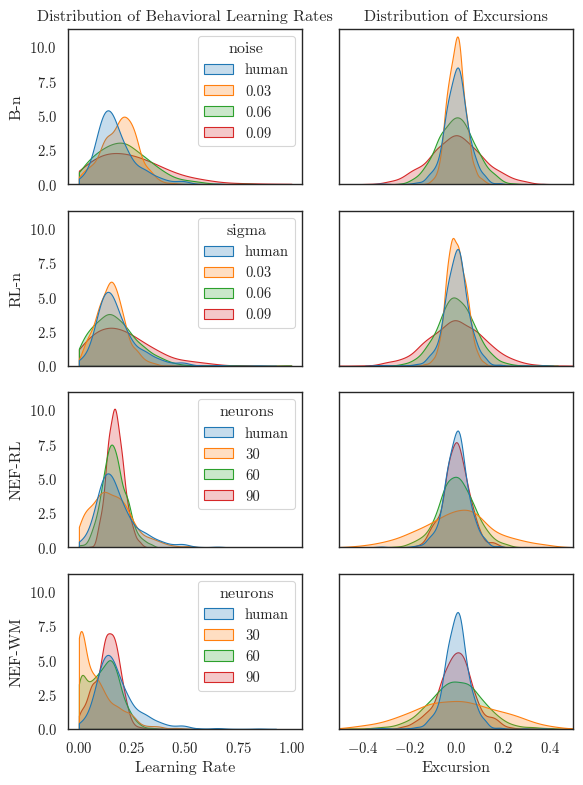

In [16]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(6, 8), sharex='col', sharey=True)
bn_query = ['human', 'B_n']
rl_query = ['human', 'RL_n']
nefrl_query = ['human', 'NEF_RL']
nefwm_query = ['human', 'NEF_WM']
sns.kdeplot(combined.query("type==@bn_query"), x='alpha', hue='noise', ax=axes[0][0], clip=[0, 1], palette=palette[:4], fill=True, common_norm=False)
sns.kdeplot(combined.query("type==@rl_query"), x='alpha', hue='sigma', ax=axes[1][0], clip=[0, 1], palette=palette[:4], fill=True, common_norm=False)
sns.kdeplot(combined.query("type==@nefrl_query"), x='alpha', hue='neurons', ax=axes[2][0], clip=[0, 1], palette=palette[:4], fill=True, common_norm=False)
sns.kdeplot(combined.query("type==@nefwm_query"), x='alpha', hue='neurons', ax=axes[3][0], clip=[0, 1], palette=palette[:4], fill=True, common_norm=False)
sns.kdeplot(combined.query("type==@bn_query"), x='excursion', hue='noise', ax=axes[0][1], clip=[-1, 1], palette=palette[:4], fill=True, common_norm=False)
sns.kdeplot(combined.query("type==@rl_query"), x='excursion', hue='sigma', ax=axes[1][1], clip=[-1, 1], palette=palette[:4], fill=True, common_norm=False)
sns.kdeplot(combined.query("type==@nefrl_query"), x='excursion', hue='neurons', ax=axes[2][1], clip=[-1, 1], palette=palette[:4], fill=True, common_norm=False)
sns.kdeplot(combined.query("type==@nefwm_query"), x='excursion', hue='neurons', ax=axes[3][1], clip=[-1, 1], palette=palette[:4], fill=True, common_norm=False)
axes[0][0].set(title='Distribution of Behavioral Learning Rates')
axes[0][1].set(title='Distribution of Excursions')
axes[0][0].set(ylabel='B-n')
axes[1][0].set(ylabel='RL-n')
axes[2][0].set(ylabel='NEF-RL')
axes[3][0].set(ylabel='NEF-WM')
axes[3][0].set(xlabel="Learning Rate")
axes[3][1].set(xlabel='Excursion', xlim=[-0.5, 0.5])
axes[0][1].get_legend().remove()
axes[1][1].get_legend().remove()
axes[2][1].get_legend().remove()
axes[3][1].get_legend().remove()
plt.tight_layout()
fig.savefig("plots/noise_demo_all_model_types.jpg", dpi=600)

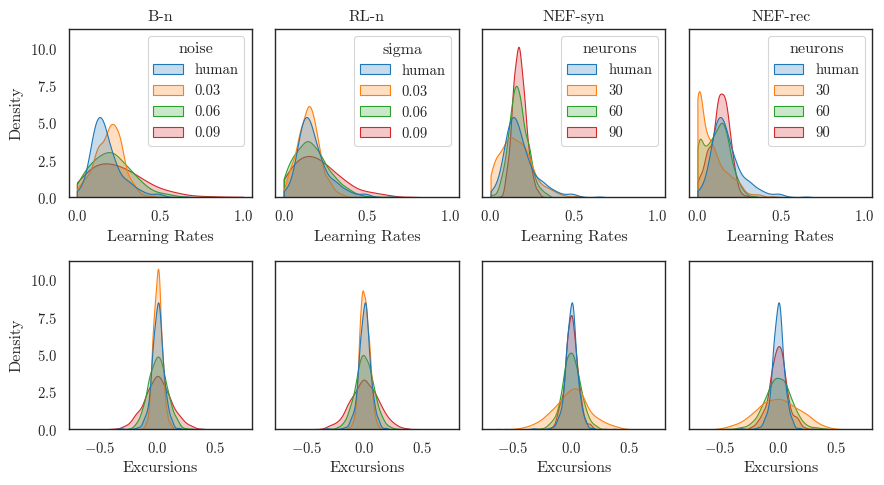

In [31]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(9, 5), sharex='row', sharey=True)
bn_query = ['human', 'B_n']
rl_query = ['human', 'RL_n']
nefrl_query = ['human', 'NEF_RL']
nefwm_query = ['human', 'NEF_WM']
sns.kdeplot(combined.query("type==@bn_query"), x='alpha', hue='noise', ax=axes[0][0], clip=[0, 1], palette=palette[:4], fill=True, common_norm=False)
sns.kdeplot(combined.query("type==@rl_query"), x='alpha', hue='sigma', ax=axes[0][1], clip=[0, 1], palette=palette[:4], fill=True, common_norm=False)
sns.kdeplot(combined.query("type==@nefrl_query"), x='alpha', hue='neurons', ax=axes[0][2], clip=[0, 1], palette=palette[:4], fill=True, common_norm=False)
sns.kdeplot(combined.query("type==@nefwm_query"), x='alpha', hue='neurons', ax=axes[0][3], clip=[0, 1], palette=palette[:4], fill=True, common_norm=False)
sns.kdeplot(combined.query("type==@bn_query"), x='excursion', hue='noise', ax=axes[1][0], clip=[-1, 1], palette=palette[:4], fill=True, common_norm=False)
sns.kdeplot(combined.query("type==@rl_query"), x='excursion', hue='sigma', ax=axes[1][1], clip=[-1, 1], palette=palette[:4], fill=True, common_norm=False)
sns.kdeplot(combined.query("type==@nefrl_query"), x='excursion', hue='neurons', ax=axes[1][2], clip=[-1, 1], palette=palette[:4], fill=True, common_norm=False)
sns.kdeplot(combined.query("type==@nefwm_query"), x='excursion', hue='neurons', ax=axes[1][3], clip=[-1, 1], palette=palette[:4], fill=True, common_norm=False)
axes[0][0].set(xlabel='Learning Rates')
axes[0][1].set(xlabel='Learning Rates')
axes[0][2].set(xlabel='Learning Rates')
axes[0][3].set(xlabel='Learning Rates')
axes[1][0].set(xlabel='Excursions')
axes[1][1].set(xlabel='Excursions')
axes[1][2].set(xlabel='Excursions')
axes[1][3].set(xlabel='Excursions')
axes[0][0].set(title='B-n')
axes[0][1].set(title='RL-n')
axes[0][2].set(title='NEF-syn')
axes[0][3].set(title='NEF-rec')
# axes[3][0].set(xlabel="Learning Rate")
# axes[3][1].set(xlabel='Excursion')
axes[1][0].get_legend().remove()
axes[1][1].get_legend().remove()
axes[1][2].get_legend().remove()
axes[1][3].get_legend().remove()
plt.tight_layout()
fig.savefig("plots/noise_demo_all_model_types.jpg", dpi=600)